In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm 
from PIL import Image, ImageOps

from keras.layers import Input
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.layers import Convolution2D,BatchNormalization
from keras.layers import GlobalAveragePooling2D,MaxPooling2D
from keras.layers import Dense,Flatten,Dropout 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import History
from keras.callbacks import ReduceLROnPlateau,LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_folder=r'/content/drive/MyDrive/train_images'
test_folder=r'/content/drive/MyDrive/test_images'

image_size = (256,256) 
inputShape=(256,256,3)
num_classes = 5 

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 image_size,
                                                 batch_size=16,
                                                 class_mode = 'categorical',
                                                 subset='training')

validation_set = train_datagen.flow_from_directory(train_folder,
                                                  image_size,
                                                  batch_size=16, 
                                                  class_mode = 'categorical',
                                                  subset='validation')


Found 4092 images belonging to 5 classes.
Found 1749 images belonging to 5 classes.


In [ ]:
def plot_model_history(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
def buildNet(num_classes):
    model = Sequential()  
    model.add(Convolution2D(32, (5,5), input_shape=inputShape, activation = 'relu'))
    model.add(BatchNormalization())

    model.add(Convolution2D(32, (5,5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2))) 
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, (5,5), activation = 'relu'))

    model.add(Convolution2D(64, (5,5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu')) 
    model.add(Dense(4, activation = 'sigmoid'))
    opt = Adam(learning_rate=0.00005) 
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [ ]:
model=buildNet(5) 
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 252, 252, 32)      2432      
                                                                 
 batch_normalization_3 (Batc  (None, 252, 252, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 248, 248, 32)      25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 124, 124, 32)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 120, 120, 64)     

In [ ]:
def trainNet(training_set, validation_set):
    #model = buildNet(num_classes)
    history = History()

    model_save = ModelCheckpoint('/content/drive/MyDrive/model1.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
    
    history = model.fit(training_set,
                        epochs = 15,
                        validation_data = validation_set,
                        callbacks = [model_save])
    
    plot_model_history(history)
    return history

Epoch 1/30
184/184 [==============================] - ETA: 0s - loss: 1.0423 - accuracy: 0.6264
Epoch 1: val_loss improved from inf to 0.91825, saving model to ./model.h5
184/184 [==============================] - 1049s 6s/step - loss: 1.0423 - accuracy: 0.6264 - val_loss: 0.9182 - val_accuracy: 0.7073
Epoch 2/30
184/184 [==============================] - ETA: 0s - loss: 0.7431 - accuracy: 0.7277
Epoch 2: val_loss improved from 0.91825 to 0.69871, saving model to ./model.h5
184/184 [==============================] - 133s 719ms/step - loss: 0.7431 - accuracy: 0.7277 - val_loss: 0.6987 - val_accuracy: 0.7647
Epoch 3/30
184/184 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.7619
Epoch 3: val_loss improved from 0.69871 to 0.58343, saving model to ./model.h5
184/184 [==============================] - 132s 719ms/step - loss: 0.6438 - accuracy: 0.7619 - val_loss: 0.5834 - val_accuracy: 0.7798
Epoch 4/30
184/184 [==============================] - ETA: 0s - loss: 0.5878

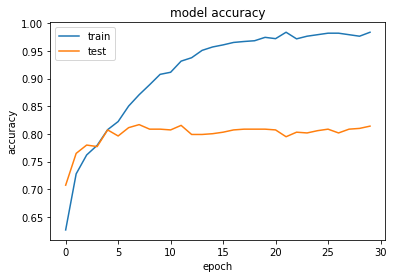

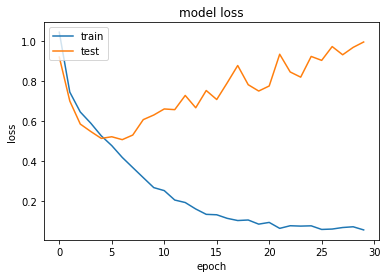

In [ ]:
history = trainNet(training_set=training_set, validation_set=validation_set)

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges): 
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes) 
    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [14]:
import pandas as pd
import numpy as np
test = pd.read_csv("/content/drive/MyDrive/submission.csv") 
test.head()

,id_code,diagnosis,pred
0,0005cfc8afb6,3,3
1,003f0afdcd15,1,4
2,006efc72b638,2,2
3,00836aaacf06,1,1
4,009245722fa4,3,4


In [11]:
mod=load_model('/content/drive/MyDrive/model1.h5')
test_gen = ImageDataGenerator(rescale = 1./255,
                              rotation_range=45)
# test_data = test_gen.flow_from_directory(test_folder,
#                                         image_size, 
#                                         batch_size=1)

test_generator = test_gen.flow_from_dataframe( 
      dataframe=test,
        directory = "/content/drive/MyDrive/test_images",  
        target_size = (256,256),
        batch_size = 1, 
        class_mode = None
        )

predicted = mod.predict(test_generator)

y_pred = np.argmax(predicted, axis=1) 
for i in range(len(y_pred)):
  print(y_pred[i])



/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 5 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1918 validated image filenames.
3
4
2
1
4
1
4
3
1
1
1
2
1
1
1
1
3
1
1
1
2
2
1
2
1
3
1
3
1
1
1
1
1
1
1
3
1
1
3
3
3
3
1
3
1
4
3
1
2
1
4
1
1
3
1
3
1
1
1
2
2
3
3
1
3
1
3
3
1
1
1
1
1
3
2
1
1
3
3
1
1
3
1
1
4
3
1
1
1
4
1
1
3
4
3
1
1
1
1
4
1
3
3
1
3
3
3
1
2
1
4
3
1
1
1
1
1
1
1
3
2
2
0
3
1
1
1
3
1
2
1
1
1
3
4
1
3
1
1
3
3
1
2
3
3
1
1
1
1
1
1
3
1
1
1
3
4
1
1
1
0
1
3
3
1
3
1
1
4
3
1
1
1
4
1
1
3
3
2
1
1
1
3
1
3
4
1
1
1
3
3
3
1
3
1
4
3
1
3
2
2
1
1
1
1
3
4
1
1
1
3
1
1
1
1
1
1
1
1
2
1
3
0
1
3
4
3
3
3
3
3
3
1
1
1
3
3
3
1
1
1
1
1
3
1
4
3
1
3
1
1
1
3
1
1
1
2
1
1
3
1
3
1
1
1
3
1
4
3
1
1
1
1
1
1
3
3
1
1
3
1
3
3
3
3
1
2
1
3
1
1
1
1
4
3
1
1
3
1
1
1
1
3
3
3
3
1
1
1
3
1
1
3
4
3
3
3
3
1
1
3
1
1
3
1
1
3
3
1
3
1
1
1
1
1
1
1
1
1
1
1
3
3
1
3
3
3
1
3
3
3
3
1
3
1
3
3
1
3
1
1
3
2
0
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
3
2
1
3
3
1
1
1
2
1
3
1
3
1
0
4
1
1
3
3
1
3
4
1
0
3
1
0
1
1
3
1
3
1
3
1
3
1
3
4
1
1
1
1
3
1
1
1
1
3
3
3
1
3
1
1
4
1
1
1
3
3
3
1
1
3
1
0
3
1
2
1
1
3
3
1
3
4
2
3
3
4
1
0
1
1
1
3
3
1
1
1
1
1
1
4
0
1
3
3
1


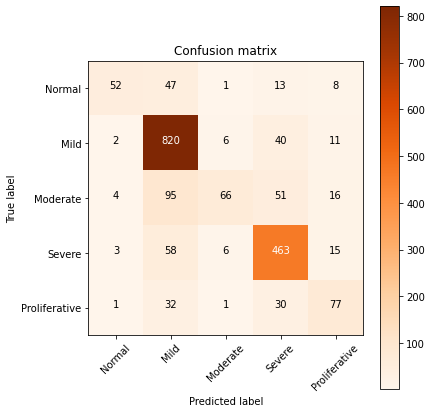

Performance Report:
Sensitivity, Specitivity and Accuracy of Normal class
0.8387096774193549 0.962823275862069 0.9588112617309698
Sensitivity, Specitivity and Accuracy of Mild class
0.779467680608365 0.9212328767123288 0.8482794577685089
Sensitivity, Specitivity and Accuracy of Moderate class
0.825 0.829393627954779 0.8290598290598291
Sensitivity, Specitivity and Accuracy of Severe class
0.7755443886097152 0.9077615298087739 0.8546433378196501
Sensitivity, Specitivity and Accuracy of Proliferative class
0.6062992125984252 0.8966666666666666 0.8607594936708861
Accuracy score is : 0.7705943691345151
F1 Score is : 0.7489022021115219


In [15]:
y_pred=test["pred"]
target=['Normal', 'Mild', 'Moderate', 'Severe', 'Proliferative']
cm=confusion_matrix(test["diagnosis"],y_pred) 
plot_confusion_matrix(cm, target,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Oranges)

print("Performance Report:")

print("Sensitivity, Specitivity and Accuracy of Normal class")

TP_Normal = cm[0][0]  
FP_Normal = cm[0][1] + cm[0][2] + cm[0][3] + cm[0][4]
FN_Normal = cm[1][0] + cm[2][0] + cm[3][0] + cm[4][0]
TN_Normal = sum(sum(cm)) - (TP_Normal + FN_Normal + FP_Normal) 


Sensitivity=TP_Normal/(TP_Normal+FN_Normal)

Specificity=TN_Normal/(TN_Normal+FP_Normal)

Accuracy=(TP_Normal+TN_Normal)/(TP_Normal+FP_Normal+FN_Normal+TN_Normal)

print(Sensitivity, Specificity, Accuracy)

print("Sensitivity, Specitivity and Accuracy of Mild class")

TP_Mild = cm[1][1]  
FP_Mild = cm[1][0] + cm[1][2] + cm[1][3] + cm[1][4]
FN_Mild = cm[0][1] + cm[2][1] + cm[3][1] + cm[4][1]
TN_Mild = sum(sum(cm)) - (TP_Mild + FN_Mild + FP_Mild) 


Sensitivity=TP_Mild/(TP_Mild+FN_Mild)

Specificity=TN_Mild/(TN_Mild+FP_Normal)

Accuracy=(TP_Mild+TN_Mild)/(TP_Mild+FP_Mild+FN_Mild+TN_Mild)

print(Sensitivity, Specificity, Accuracy)

print("Sensitivity, Specitivity and Accuracy of Moderate class")

TP_Moderate = cm[2][2]  
FP_Moderate = cm[2][0] + cm[2][1] + cm[2][3] + cm[2][4]
FN_Moderate = cm[0][2] + cm[1][2] + cm[3][2] + cm[4][2]
TN_Moderate = sum(sum(cm)) - (TP_Mild + FN_Mild + FP_Mild) 


Sensitivity=TP_Moderate/(TP_Moderate+FN_Moderate)

Specificity=TN_Moderate/(TN_Mild+FP_Moderate)

Accuracy=(TP_Moderate+TN_Moderate)/(TP_Moderate+FP_Moderate+FN_Moderate+TN_Moderate)

print(Sensitivity, Specificity, Accuracy)

print("Sensitivity, Specitivity and Accuracy of Severe class")

TP_Severe = cm[3][3]  
FP_Severe = cm[3][0] + cm[3][1] + cm[3][2] + cm[3][4]
FN_Severe = cm[0][3] + cm[1][3] + cm[2][3] + cm[4][3]
TN_Severe = sum(sum(cm)) - (TP_Mild + FN_Mild + FP_Mild) 


Sensitivity=TP_Severe/(TP_Severe+FN_Severe)

Specificity=TN_Severe/(TN_Mild+FP_Severe)

Accuracy=(TP_Severe+TN_Severe)/(TP_Severe+FP_Severe+FN_Severe+TN_Severe)

print(Sensitivity, Specificity, Accuracy)


print("Sensitivity, Specitivity and Accuracy of Proliferative class")

TP_Proliferative = cm[4][4]  
FP_Proliferative = cm[4][0] + cm[4][1] + cm[4][3] + cm[4][3]
FN_Proliferative = cm[0][4] + cm[1][4] + cm[2][4] + cm[3][4]
TN_Proliferative = sum(sum(cm)) - (TP_Mild + FN_Mild + FP_Mild) 


Sensitivity=TP_Proliferative/(TP_Proliferative+FN_Proliferative)

Specificity=TN_Proliferative/(TN_Mild+FP_Proliferative)

Accuracy=(TP_Proliferative+TN_Proliferative)/(TP_Proliferative+FP_Proliferative+FN_Proliferative+TN_Proliferative)

print(Sensitivity, Specificity, Accuracy)
print('Accuracy score is :', metrics.accuracy_score(test["diagnosis"],y_pred)) 
print('F1 Score is :', metrics.f1_score(test["diagnosis"],y_pred,average='weighted'))  